## Accelerate Inference: Neural Network Pruning

In [6]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.layers import *

print(tf.version.VERSION)

2.9.2


In [7]:
# untar
!tar -xvzf dataset.tar.gz

# load train
train_images = pickle.load(open('train_images.pkl', 'rb'))
train_labels = pickle.load(open('train_labels.pkl', 'rb'))

# load val
val_images = pickle.load(open('val_images.pkl', 'rb'))
val_labels = pickle.load(open('val_labels.pkl', 'rb'))

train_images.pkl
train_labels.pkl
val_images.pkl
val_labels.pkl


# Training
BatchNorm is used initially to calculate channel scaling factors. BatchNorm dropped during pruning.

In [8]:
model = models.Sequential()

model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5), input_shape=(25,25,3)))
model.add(BatchNormalization(center=False))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization(center=False))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization(center=False))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization(center=False))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(5))
model.add(Activation('softmax'))

In [9]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 25, 25, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 25, 25, 32)       96        
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 25, 25, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 23, 23, 32)        9248      
                                                                 
 batch_normalization_5 (Batc  (None, 23, 23, 32)       96        
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 23, 23, 32)       

In [10]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, batch_size=32, epochs=50,
                    validation_data=(val_images, val_labels))

Epoch 1/50
703/703 [==============================] - 6s 7ms/step - loss: 1.6268 - accuracy: 0.3222 - val_loss: 1.3809 - val_accuracy: 0.4380
Epoch 2/50
703/703 [==============================] - 4s 5ms/step - loss: 1.3834 - accuracy: 0.4033 - val_loss: 1.2938 - val_accuracy: 0.4665
Epoch 3/50
703/703 [==============================] - 4s 5ms/step - loss: 1.3030 - accuracy: 0.4509 - val_loss: 1.2078 - val_accuracy: 0.4974
Epoch 4/50
703/703 [==============================] - 4s 5ms/step - loss: 1.2596 - accuracy: 0.4733 - val_loss: 1.1993 - val_accuracy: 0.4871
Epoch 5/50
703/703 [==============================] - 4s 5ms/step - loss: 1.2192 - accuracy: 0.4958 - val_loss: 1.1810 - val_accuracy: 0.5097
Epoch 6/50
703/703 [==============================] - 4s 5ms/step - loss: 1.1845 - accuracy: 0.5120 - val_loss: 1.1403 - val_accuracy: 0.5228
Epoch 7/50
703/703 [==============================] - 4s 5ms/step - loss: 1.1558 - accuracy: 0.5274 - val_loss: 1.0859 - val_accuracy: 0.5537
Epoch 

In [11]:
results = model.evaluate(val_images, val_labels, batch_size=128)

20/20 [==============================] - 0s 8ms/step - loss: 0.7603 - accuracy: 0.7121


In [12]:
model.save_weights("trained_model.h5")

# Pruning
Channel scaling factors are first calculated from model with BatchNorm (using BatchNorm scaling factor) and if they are less than the threshold value, they are set to zero considering the corresponding channels are unimportant. The channel to be dropped are kept fixed while retraining assuming that the unimportant channels remain the same with/without BathcNorm and during retraining as well.

In [13]:
def sparsity(weights):
 
    zero_weights = 0
  
    for i in range(len(weights)):
      
        curr_zero_weights = tf.reduce_sum((weights[i]==0)*1).numpy()
        zero_weights += curr_zero_weights

    return zero_weights / 592933

In [14]:
def get_nonbatchnorm_model(model):

    new_model = models.Sequential()

    for i, layer in enumerate(model.layers):
        if not isinstance(layer, keras.layers.BatchNormalization):
            new_model.add(layer)
    
    return new_model

In [15]:
all_thres = np.arange(0.92, 1.05, 0.01)
all_models = []
loops = 2

for thres in all_thres:

    print('\nthreshold', thres)

    model.load_weights('trained_model.h5')
    all_sparse_gamma = []

    for i, layer in enumerate(model.layers):
        if isinstance(layer, keras.layers.BatchNormalization):

            gamma = layer.get_weights()[0]
            sparse_gamma = (gamma > thres).astype(float)

            # save un/important channels
            all_sparse_gamma.append(sparse_gamma)

            conv_weight = model.layers[i-1].get_weights()[0]
            conv_bias = model.layers[i-1].get_weights()[1]

            conv_weight *= sparse_gamma
            conv_bias *= sparse_gamma

            model.layers[i-1].set_weights([conv_weight, conv_bias])

    pruned_model = get_nonbatchnorm_model(model)
    pruned_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001, decay=1e-6),
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy'])

    for i in tqdm(range(loops), total=loops):

        history = pruned_model.fit(train_images, train_labels, batch_size=32, epochs=2,
                                  validation_data=(val_images, val_labels), verbose=False)

        # drop/keep convolution layer channel weights
        conv_count = 0

        for i, layer in enumerate(pruned_model.layers):
            if isinstance(layer, keras.layers.Conv2D):

                sparse_gamma = all_sparse_gamma[conv_count]
                conv_count += 1

                conv_weight = layer.get_weights()[0]
                conv_bias = layer.get_weights()[1]

                conv_weight *= sparse_gamma
                conv_bias *= sparse_gamma

                layer.set_weights([conv_weight, conv_bias])
        
        results = pruned_model.evaluate(val_images, val_labels, batch_size=128)
    
    all_models.append((thres, pruned_model, results, sparsity(pruned_model.get_weights())))


threshold 0.92


  0%|          | 0/2 [00:00<?, ?it/s]

20/20 [==============================] - 0s 5ms/step - loss: 1.1119 - accuracy: 0.5493


 50%|█████     | 1/2 [00:11<00:11, 11.31s/it]

20/20 [==============================] - 0s 5ms/step - loss: 1.0168 - accuracy: 0.5988


100%|██████████| 2/2 [00:17<00:00,  8.86s/it]


threshold 0.93



  0%|          | 0/2 [00:00<?, ?it/s]

20/20 [==============================] - 0s 5ms/step - loss: 1.1249 - accuracy: 0.5505


 50%|█████     | 1/2 [00:11<00:11, 11.27s/it]

20/20 [==============================] - 0s 4ms/step - loss: 1.0254 - accuracy: 0.6008


100%|██████████| 2/2 [00:17<00:00,  8.87s/it]



threshold 0.9400000000000001


  0%|          | 0/2 [00:00<?, ?it/s]

20/20 [==============================] - 0s 5ms/step - loss: 1.1317 - accuracy: 0.5442


 50%|█████     | 1/2 [00:11<00:11, 11.24s/it]

20/20 [==============================] - 0s 5ms/step - loss: 1.0520 - accuracy: 0.5830


100%|██████████| 2/2 [00:21<00:00, 10.93s/it]


threshold 0.9500000000000001



  0%|          | 0/2 [00:00<?, ?it/s]

20/20 [==============================] - 0s 4ms/step - loss: 1.2032 - accuracy: 0.4982


 50%|█████     | 1/2 [00:07<00:07,  7.20s/it]

20/20 [==============================] - 0s 5ms/step - loss: 1.0744 - accuracy: 0.5711


100%|██████████| 2/2 [00:17<00:00,  8.92s/it]


threshold 0.9600000000000001



  0%|          | 0/2 [00:00<?, ?it/s]

20/20 [==============================] - 0s 4ms/step - loss: 1.1993 - accuracy: 0.5141


 50%|█████     | 1/2 [00:06<00:06,  6.92s/it]

20/20 [==============================] - 0s 5ms/step - loss: 1.0527 - accuracy: 0.5909


100%|██████████| 2/2 [00:17<00:00,  8.78s/it]


threshold 0.9700000000000001



  0%|          | 0/2 [00:00<?, ?it/s]

20/20 [==============================] - 0s 4ms/step - loss: 1.2372 - accuracy: 0.4974


 50%|█████     | 1/2 [00:07<00:07,  7.15s/it]

20/20 [==============================] - 0s 6ms/step - loss: 1.1256 - accuracy: 0.5501


100%|██████████| 2/2 [00:17<00:00,  8.93s/it]


threshold 0.9800000000000001



  0%|          | 0/2 [00:00<?, ?it/s]

20/20 [==============================] - 0s 5ms/step - loss: 1.3549 - accuracy: 0.4705


 50%|█████     | 1/2 [00:11<00:11, 11.51s/it]

20/20 [==============================] - 0s 4ms/step - loss: 1.2128 - accuracy: 0.5133


100%|██████████| 2/2 [00:17<00:00,  8.91s/it]



threshold 0.9900000000000001


  0%|          | 0/2 [00:00<?, ?it/s]

20/20 [==============================] - 0s 5ms/step - loss: 1.4439 - accuracy: 0.4396


 50%|█████     | 1/2 [00:11<00:11, 11.20s/it]

20/20 [==============================] - 0s 4ms/step - loss: 1.3297 - accuracy: 0.4444


100%|██████████| 2/2 [00:17<00:00,  8.80s/it]


threshold 1.0



  0%|          | 0/2 [00:00<?, ?it/s]

20/20 [==============================] - 0s 5ms/step - loss: 1.4947 - accuracy: 0.3873


 50%|█████     | 1/2 [00:11<00:11, 11.18s/it]

20/20 [==============================] - 0s 4ms/step - loss: 1.3961 - accuracy: 0.3933


100%|██████████| 2/2 [00:17<00:00,  8.76s/it]



threshold 1.0100000000000002


  0%|          | 0/2 [00:00<?, ?it/s]

20/20 [==============================] - 0s 5ms/step - loss: 1.5690 - accuracy: 0.3101


 50%|█████     | 1/2 [00:11<00:11, 11.20s/it]

20/20 [==============================] - 0s 5ms/step - loss: 1.4775 - accuracy: 0.3648


100%|██████████| 2/2 [00:21<00:00, 10.91s/it]


threshold 1.02



  0%|          | 0/2 [00:00<?, ?it/s]

20/20 [==============================] - 0s 4ms/step - loss: 1.5965 - accuracy: 0.2828


 50%|█████     | 1/2 [00:07<00:07,  7.10s/it]

20/20 [==============================] - 0s 5ms/step - loss: 1.5171 - accuracy: 0.3450


100%|██████████| 2/2 [00:13<00:00,  6.70s/it]


threshold 1.0300000000000002



  0%|          | 0/2 [00:00<?, ?it/s]

20/20 [==============================] - 0s 6ms/step - loss: 1.6013 - accuracy: 0.2471


 50%|█████     | 1/2 [00:11<00:11, 11.17s/it]

20/20 [==============================] - 0s 4ms/step - loss: 1.5778 - accuracy: 0.2756


100%|██████████| 2/2 [00:17<00:00,  8.77s/it]


threshold 1.04



  0%|          | 0/2 [00:00<?, ?it/s]

20/20 [==============================] - 0s 5ms/step - loss: 1.6104 - accuracy: 0.1925


 50%|█████     | 1/2 [00:11<00:11, 11.14s/it]

20/20 [==============================] - 0s 4ms/step - loss: 1.6089 - accuracy: 0.1925


100%|██████████| 2/2 [00:17<00:00,  8.71s/it]


# Pareto

In [16]:
accs = []
spars = []

for i in all_models:

    accs.append(i[2][1])
    spars.append(i[3])

Text(0.5, 1.0, 'Network Slimming')

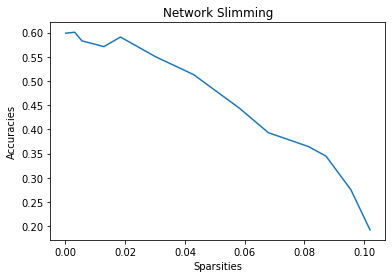

In [17]:
plt.plot(spars, accs)
plt.xlabel('Sparsities')
plt.ylabel('Accuracies')
plt.title('Network Slimming')

In [18]:
np.savetxt('ns_accuracies.csv', accs, delimiter=',')
np.savetxt('ns_sparsities.csv', spars, delimiter=',')

# Pick Best Model

In [19]:
def score(acc, sparsity):

    return (acc + sparsity) / 2

In [20]:
# get model with best score
all_models.sort(key=lambda m: score(m[2][1], m[3]))
best_model = all_models[-1][1]

results = best_model.evaluate(val_images, val_labels, batch_size=128)
final_score = score(all_models[-1][2][1], all_models[-1][3])

print('threshold:', all_models[-1][0])
print('results: ', all_models[-1][2])
print('sparsity: ', all_models[-1][3])
print('final_score', final_score)

best_model.save_weights('my_model_weights_3.h5')

20/20 [==============================] - 0s 4ms/step - loss: 1.6089 - accuracy: 0.1925
threshold: 0.9600000000000001
results:  [1.0526989698410034, 0.5908910632133484]
sparsity:  0.01843547247328113
final_score 0.30466326784331477
